In [6]:
import torchvision
import torch
from torch import nn

from torchinfo import summary

device = "mps" if torch.mps.is_available() else "cpu"
device

'mps'

In [3]:
# put them into a function
def create_effnetb2_model(num_classes: int = 3,
                          seed: int = 42):
    
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    #freeze layers
    for param in model.parameters():
        param.requires_grad = False

    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3,
                   inplace=True),
        nn.Linear(in_features=1408,
                  out_features=num_classes)
    )
    return model, transforms

In [4]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=101)

In [9]:
summary(model=effnetb2,
        input_size=(1, 3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]          [1, 101]                  --                        Partial
├─Sequential (features)                                      [1, 3, 224, 224]          [1, 1408, 7, 7]           --                        False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]          [1, 32, 112, 112]         --                        False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]          [1, 32, 112, 112]         (864)                     False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]         [1, 32, 112, 112]         (64)                      False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]         [1, 32, 112, 112]         --         

In [11]:
train_transforms = torchvision.transforms.Compose(
    [torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms]
)
train_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

In [12]:
from torchvision import datasets

from pathlib import Path

data_dir = Path("data")

train_data = datasets.Food101(root=data_dir,
                              split="train",
                              transform=train_transforms,
                              download=True)

test_data = datasets.Food101(root=data_dir,
                             split="test",
                             transform=effnetb2_transforms, # don't apply augmentation for test images
                             download=True)


100%|██████████| 5.00G/5.00G [05:24<00:00, 15.4MB/s]  


In [13]:
food101_class_names = train_data.classes
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [14]:
len(train_data)*0.2, len(test_data)*0.2

(15150.0, 5050.0)

In [16]:
from torch.utils.data import random_split

def split_dataset(dataset: torchvision.datasets,
                  split_size: float=0.2,
                  seed:int=42):
    length1 = int(len(dataset)* split_size)
    length2 = len(dataset) - length1

    print(f"Splitting dataset of length {len(dataset)} into {length1} and {length2}")

    random_split_1, random_split_2 = random_split(dataset,
                                                  lengths=[length1, length2],
                                                  generator=torch.manual_seed(seed))
    return random_split_1, random_split_2

In [17]:
train_data_food101_20_percent, _ = split_dataset(train_data)
test_data_food101_20_percent, _ = split_dataset(test_data)

Splitting dataset of length 75750 into 15150 and 60600
Splitting dataset of length 25250 into 5050 and 20200


In [19]:
import os

NUM_WORKER = os.cpu_count()
BATCH_SIZE = 32

In [21]:
train_dataloader_food101_20_percent = torch.utils.data.DataLoader(
    dataset=train_data_food101_20_percent,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True
)

test_dataloader_food101_20_percent = torch.utils.data.DataLoader(
    dataset=test_data_food101_20_percent,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=False
)

In [22]:
len(train_dataloader_food101_20_percent), len(test_dataloader_food101_20_percent)

(474, 158)

In [ ]:
# to train
# 5 epochs
# optimizer: Adam
# loss function: CrossEntropyLoss(label_smoothing=0.1) <-- label_smoothing: a regularization technique to prevent overfitting
from utils import engine

loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(params=effnetb2.parameters(), lr=1e-3)

torch.manual_seed(42)
torch.mps.manual_seed(42)

effnetb2_results = engine.train(
    model=effnetb2,
    train_dataloader=train_dataloader_food101_20_percent,
    test_dataloader=test_dataloader_food101_20_percent,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=5,
    device=device
)


/Users/mikeqin/code/ml-training/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 20%|██        | 1/5 [04:16<17:06, 256.74s/it]

Epoch: 1 | train_loss: 3.6470 | train_acc: 0.2816 | test_loss: 2.7701 | test_acc: 0.4872


 40%|████      | 2/5 [08:30<12:44, 254.89s/it]

Epoch: 2 | train_loss: 2.8629 | train_acc: 0.4392 | test_loss: 2.4730 | test_acc: 0.5369


 60%|██████    | 3/5 [12:45<08:30, 255.06s/it]

Epoch: 3 | train_loss: 2.6418 | train_acc: 0.4888 | test_loss: 2.3527 | test_acc: 0.5588


 80%|████████  | 4/5 [17:00<04:14, 254.89s/it]

Epoch: 4 | train_loss: 2.5421 | train_acc: 0.5074 | test_loss: 2.3080 | test_acc: 0.5701


100%|██████████| 5/5 [21:17<00:00, 255.56s/it]

Epoch: 5 | train_loss: 2.4988 | train_acc: 0.5222 | test_loss: 2.2766 | test_acc: 0.5783


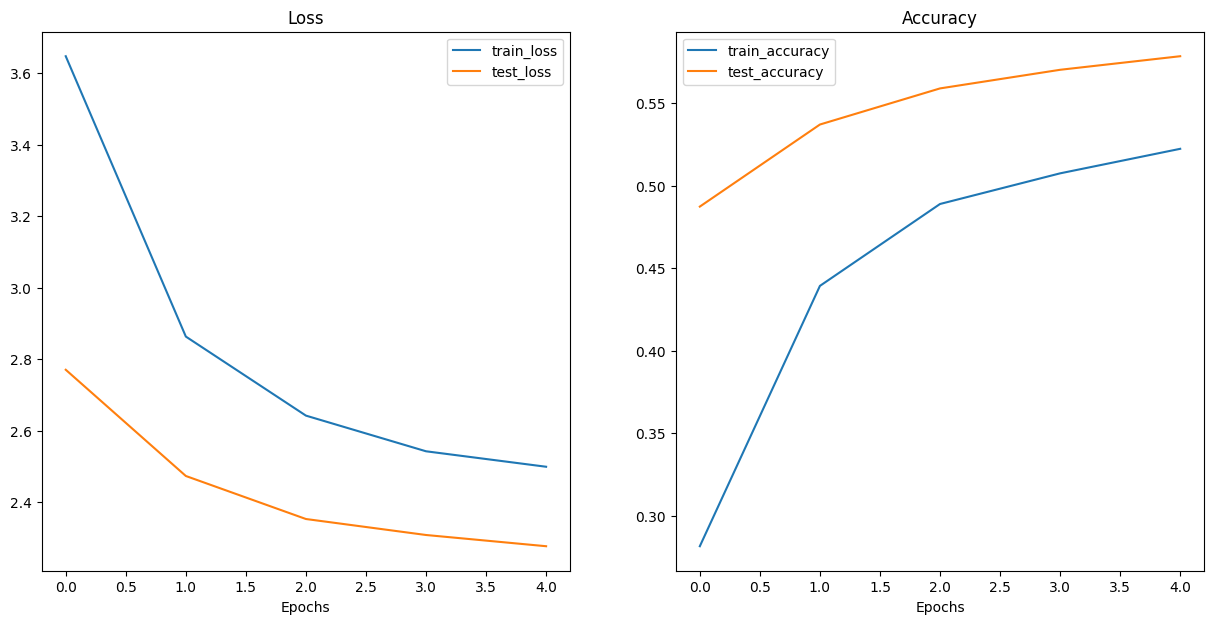

In [26]:
# plot the loss curve
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

In [ ]:
# save the model
from utils import utils

effnetb2_food101_model_path="pretrained_effnetb2_feature_extractor_food101_20_percent.pth"

utils.save_model(model=effnetb2,
                 target_dir="models/",
                 model_name=effnetb2_food101_model_path)

[INFO] Saving model to: models/pretrained_effnetb2_feature_extractor_food101_20_percent.pth


In [29]:
# load the model back
loaded_effnetb2, loaded_effnetb2_transforms = create_effnetb2_model(num_classes=101)
loaded_effnetb2.load_state_dict(torch.load("models/pretrained_effnetb2_feature_extractor_food101_20_percent.pth"))


<All keys matched successfully>

In [30]:
# check model size
from pathlib import Path

pretrained_effnetb2_food101_model_size = Path(
    "models", effnetb2_food101_model_path).stat().st_size // (1024*1024)

pretrained_effnetb2_food101_model_size

30

In [31]:
from timeit import default_timer as timer

def predict(img) -> tuple[dict, float]:
  # Start a timer
  start_time = timer()

  # Transform the input image for use with EffNetB2
  img = loaded_effnetb2_transforms(img).unsqueeze(0) # unsqueeze = add batch dimension on 0th index

  # Put model into eval mode, make prediction
  loaded_effnetb2.eval()
  with torch.inference_mode():
    # Pass transformed image through the model and turn the prediction logits into probaiblities
    pred_probs = torch.softmax(loaded_effnetb2(img), dim=1)

  # Create a prediction label and prediction probability dictionary
  pred_labels_and_probs = {food101_class_names[i]: float(pred_probs[0][i]) for i in range(len(food101_class_names))}

  # Calculate pred time
  end_time = timer()
  pred_time = round(end_time - start_time, 4)

  # Return pred dict and pred time
  return pred_labels_and_probs, pred_time

In [ ]:
import gradio as gr
# Create title, description and article
title = "FoodVision BIG"
description = "An [EfficientNetB2 feature extractor](https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.efficientnet_b2) computer vision model to classify images [101 classes of food from the Food101 dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/food101_class_names.txt)."
article = "Created at [PyTorch Model Deployment](https://www.learnpytorch.io/pytorch_model_deployment/urning-our-foodvision-big-model-into-a-deployable-app)."

# Create example list
example_list = [["/Users/mikeqin/code/ml-training/pytorch-deep-learning/git/pytorch-deep-learning/demos/foodvision_big/examples/" + example] for example in os.listdir("/Users/mikeqin/code/ml-training/pytorch-deep-learning/git/pytorch-deep-learning/demos/foodvision_big/examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # maps inputs to outputs
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=5, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch() 

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.


Created dataset file at: .gradio/flagged/dataset1.csv
